<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2011/Assignment%2011%20-%20Model%20Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir(r'/content')
!git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 11/asgnmt11')

Cloning into 'TSAI-EVA40-Assignments'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 933 (delta 69), reused 16 (delta 10), pack-reused 836
Receiving objects: 100% (933/933), 25.12 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (534/534), done.


In [0]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
import torch
from torchsummary import summary
from assignment11_model import Net

from LR_Finder_acc import *
from LR_Min_Max import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy

In [3]:
### Data Loading
trainloader,testloader = cifar_data_loader(BatchSize=512)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = Net().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Estimating LR Max


Learning rate search finished. See the graph with {finder_name}.plot()


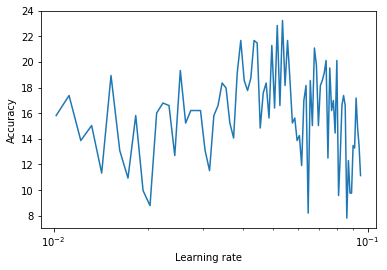

53    0.053582
Name: lr, dtype: float64

In [5]:
lr_max = LR_Max(net,trainloader,1e-4,0.1,iters = 100,mode = 'linear')
lr_max

## Estimating LR Min


In [6]:
lr_min =  LR_Min(trainloader,lr_max)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.6864758729934692 Batch_id=97 Accuracy=32.09: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.4537736177444458 Batch_id=97 Accuracy=42.25: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.2626445293426514 Batch_id=97 Accuracy=48.51: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.352846384048462 Batch_id=97 Accuracy=54.20: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.245150566101074 Batch_id=97 Accuracy=18.53: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.9364467859268188 Batch_id=97 Accuracy=30.43: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.8123681545257568 Batch_id=97 Accuracy=39.77: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.3776859045028687 Batch_id=97 Accuracy=46.40: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.369278907775879 Batch_id=97 Accuracy=51.58: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.0526485443115234 Batch_id=97 Accuracy=22.64: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.5622204542160034 Batch_id=97 Accuracy=38.97: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.424344778060913 Batch_id=97 Accuracy=47.15: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.2371323108673096 Batch_id=97 Accuracy=52.80: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.1275399923324585 Batch_id=97 Accuracy=57.83: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.913208246231079 Batch_id=97 Accuracy=23.98: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.5413416624069214 Batch_id=97 Accuracy=40.67: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.4168506860733032 Batch_id=97 Accuracy=48.21: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.3225911855697632 Batch_id=97 Accuracy=54.43: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.2008074522018433 Batch_id=97 Accuracy=59.07: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.623533844947815 Batch_id=97 Accuracy=28.68: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.5414588451385498 Batch_id=97 Accuracy=43.53: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.2320060729980469 Batch_id=97 Accuracy=50.85: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.0964328050613403 Batch_id=97 Accuracy=55.67: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.0959657430648804 Batch_id=97 Accuracy=59.85: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6333837509155273 Batch_id=97 Accuracy=27.13: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.4821150302886963 Batch_id=97 Accuracy=43.15: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.2768219709396362 Batch_id=97 Accuracy=51.12: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.171373724937439 Batch_id=97 Accuracy=56.15: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.2728192806243896 Batch_id=97 Accuracy=59.43: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]


In [7]:
lr_min

0.005358181818181819